In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [2]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 51.14%
Test size ≃ 48.86%


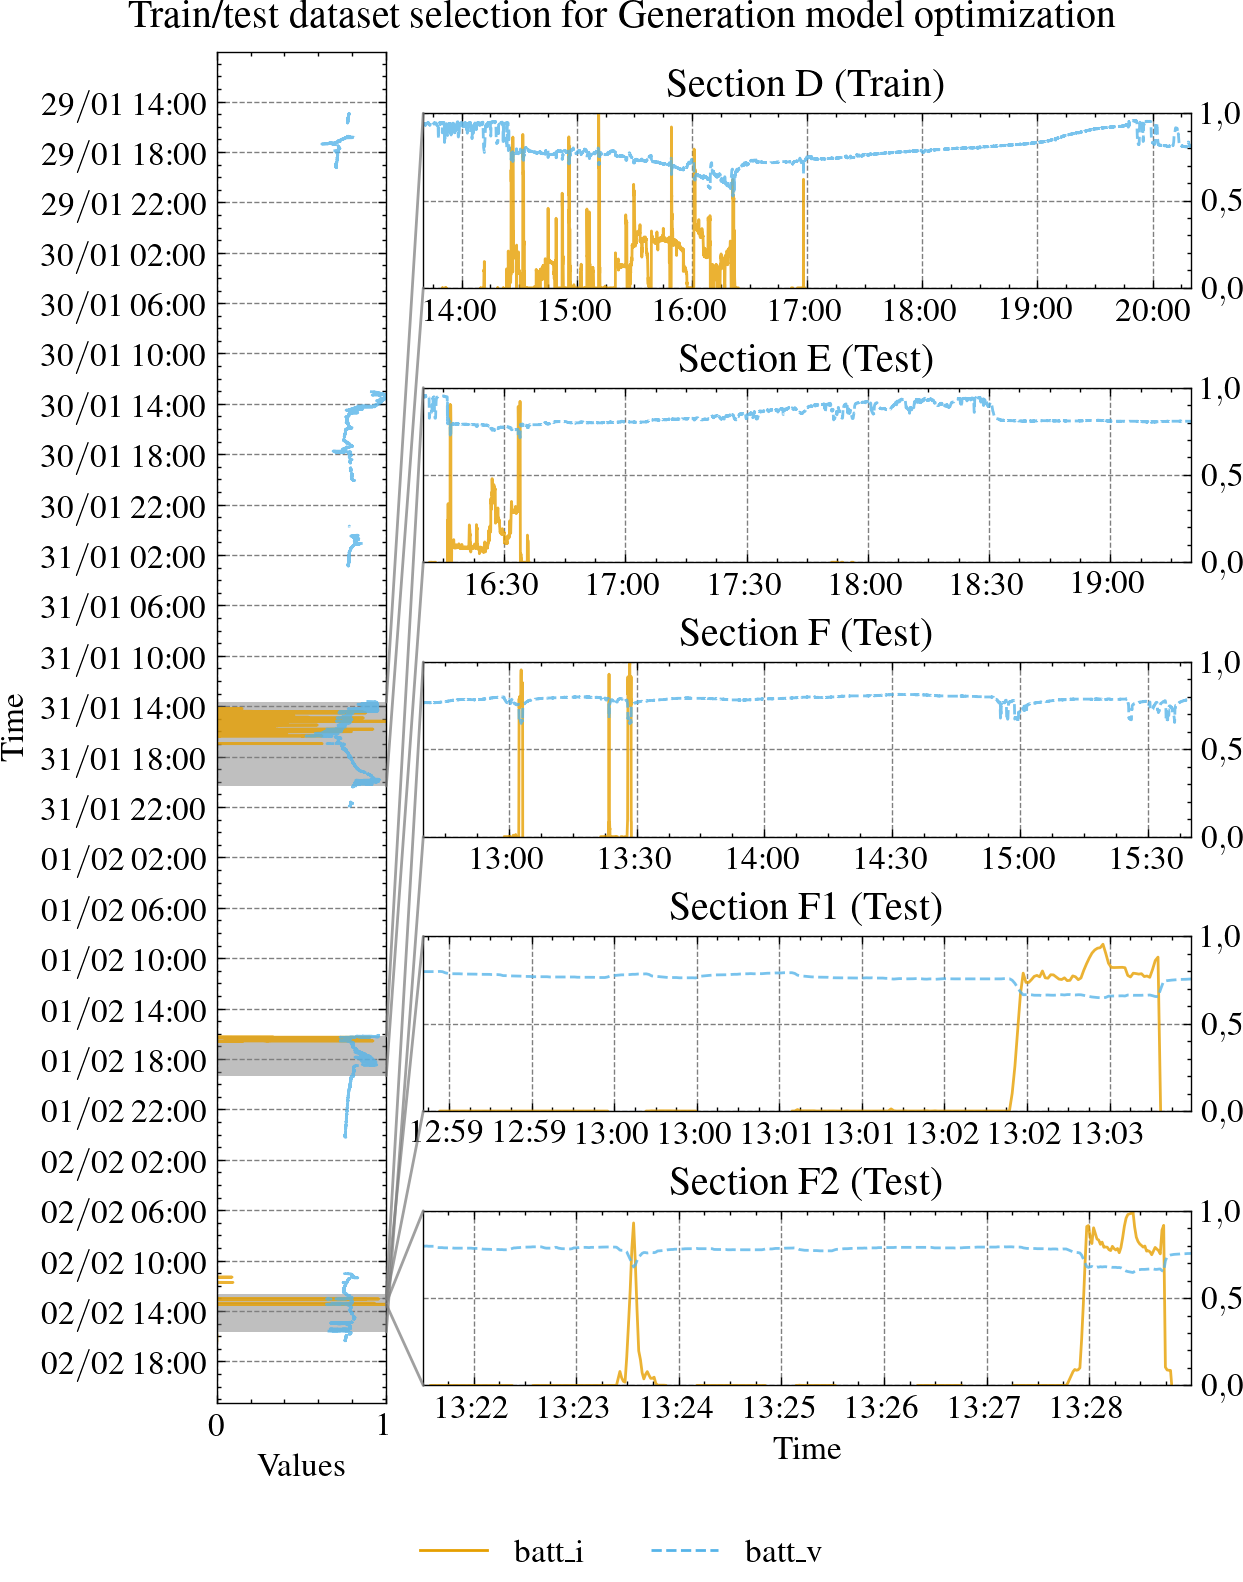

In [3]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F', 'Section F1', 'Section F2']]

train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


## Frequency view

In [6]:
def eval_poly(coeffs, x):
    result = 0.0
    for c in reversed(coeffs[1:]):
        result = (result + c) * x
    return result + coeffs[0]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

def preprocess_battery_dynamics(
    df: pd.DataFrame,
    nominal_Q: float,
    initial_SOC: float,
    batt_k_V_OC_coeffs: np.ndarray,
    R0: float,
) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Preprocess raw battery data to isolate the dynamic (RC) subsystem.

    Parameters
    ----------
    df : DataFrame
        Must contain 't', 'batt_v', 'batt_i' and a DatetimeIndex with constant spacing.
    nominal_Q : float
        Nominal capacity [Ah].
    initial_SOC : float
        Initial SOC fraction [0..1] for capacity integration.
    batt_k_V_OC_coeffs : array-like
        Polynomial OCV coefficients a_0..a_n for OCV(z) = sum a_k z^k.
    R0 : float
        Ohmic resistance [Ω] (current guess).

    Returns
    -------
    u : ndarray
        Input current array (A).
    y_dyn : ndarray
        Dynamic voltage (V) with OCV and R0·I removed.
    dt : float
        Sampling interval [s].
    """
    # Ensure sorted index
    df = df.sort_index()

    # Compute Q(t) and SOC
    df_tmp = df.copy()
    compute_df_capacity(df_tmp, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_tmp, nominal_Q, inplace=True)

    batt_z = df_tmp["batt_z"].to_numpy()
    batt_v = df_tmp["batt_v"].to_numpy()
    batt_i = df_tmp["batt_i"].to_numpy()

    # OCV(z)
    batt_ocv = eval_poly(batt_k_V_OC_coeffs, batt_z)

    # Dynamic component: remove OCV and R0*I
    # sign convention: your model uses V = OCV - R0*I - sum(v_Ci)
    # so v_dyn ≈ -sum(v_Ci) when we add R0*I back.
    v_dyn = batt_v - batt_ocv + R0 * batt_i

    # Input
    u = batt_i

    # Sampling interval from index
    dt = (df_tmp.index[1] - df_tmp.index[0]).total_seconds()

    return u, v_dyn, dt

def estimate_frf(u: np.ndarray,
                 y: np.ndarray,
                 dt: float,
                 nperseg: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    """
    Estimate empirical FRF H(f) = S_yu / S_uu using Welch CSD.

    Parameters
    ----------
    u : ndarray
        Input signal.
    y : ndarray
        Output signal (dynamic voltage).
    dt : float
        Sampling interval [s].
    nperseg : int
        Segment length for Welch / CSD.

    Returns
    -------
    f : ndarray
        Frequency vector [Hz].
    H : ndarray
        Complex FRF estimate H(f).
    """
    fs = 1.0 / dt

    f, S_yu = signal.csd(y, u, fs=fs, nperseg=nperseg)
    _, S_uu = signal.csd(u, u, fs=fs, nperseg=nperseg)

    H = S_yu / S_uu
    return f, H

def detect_break_frequencies(
    f: np.ndarray,
    H: np.ndarray,
    min_freq: float | None = None,
    max_freq: float | None = None,
    min_prominence: float = 0.1,
    max_peaks: int = 5,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Detect candidate RC break frequencies from |H(f)|.

    Parameters
    ----------
    f : ndarray
        Frequency vector [Hz].
    H : ndarray
        Complex FRF.
    min_freq, max_freq : float or None
        Frequency window [Hz] to consider. None = no limit.
    min_prominence : float
        Minimum peak prominence in dB/dec derivative (tune as needed).
    max_peaks : int
        Maximum number of break frequency candidates to return.

    Returns
    -------
    f_peaks : ndarray
        Candidate break frequencies [Hz] (sorted).
    tau_estimates : ndarray
        Corresponding tau estimates [s] ≈ 1/(2π f_peak).
    """
    mag = np.abs(H)
    # Avoid zeros; restrict to positive frequencies
    mask = (f > 0)
    if min_freq is not None:
        mask &= (f >= min_freq)
    if max_freq is not None:
        mask &= (f <= max_freq)

    f_sel = f[mask]
    mag_sel = mag[mask]

    # Work in log-log space
    log_f = np.log10(f_sel)
    log_mag = np.log10(mag_sel + 1e-16)

    # Numerical derivative d(log|H|)/d(log f)
    dlogmag_dlogf = np.gradient(log_mag, log_f)

    # Use magnitude of derivative changes (curvature proxy)
    # Option 1: directly use derivative magnitude
    deriv_abs = np.abs(dlogmag_dlogf)

    # Option 2: smooth a bit (optional)
    # from scipy.ndimage import gaussian_filter1d
    # deriv_abs = gaussian_filter1d(deriv_abs, sigma=1.0)

    # Find peaks in derivative magnitude
    peaks, _ = signal.find_peaks(deriv_abs, prominence=min_prominence)

    if len(peaks) == 0:
        return np.array([]), np.array([])

    # Sort peaks by frequency (low to high) and limit count
    f_peaks = f_sel[peaks]
    order = np.argsort(f_peaks)
    f_peaks = f_peaks[order][:max_peaks]

    # Tau estimate for each break
    tau_est = 1.0 / (2 * np.pi * f_peaks)

    return f_peaks, tau_est

def suggest_tau_bounds(
    tau_estimates: np.ndarray,
    factor_low: float = 0.2,
    factor_high: float = 5.0,
) -> list[tuple[float, float]]:
    """
    Suggest (min, max) bounds for each tau, around the estimated τ.

    Parameters
    ----------
    tau_estimates : ndarray
        Estimated τ values [s].
    factor_low, factor_high : float
        Multiplicative factors for lower/upper bounds.

    Returns
    -------
    bounds : list of (tau_min, tau_max)
    """
    bounds = []
    for tau in tau_estimates:
        tau_min = tau * factor_low
        tau_max = tau * factor_high
        bounds.append((tau_min, tau_max))
    return bounds


Candidate break frequencies [Hz]: [0.00195312 0.00488281]
Estimated taus [s]: [81.48733086 32.59493235]
tau_1 bounds ≈ [16.30, 407.44] s
tau_2 bounds ≈ [6.52, 162.97] s


[(6.518986469044034, 162.97466172610083),
 (16.297466172610083, 407.4366543152521)]

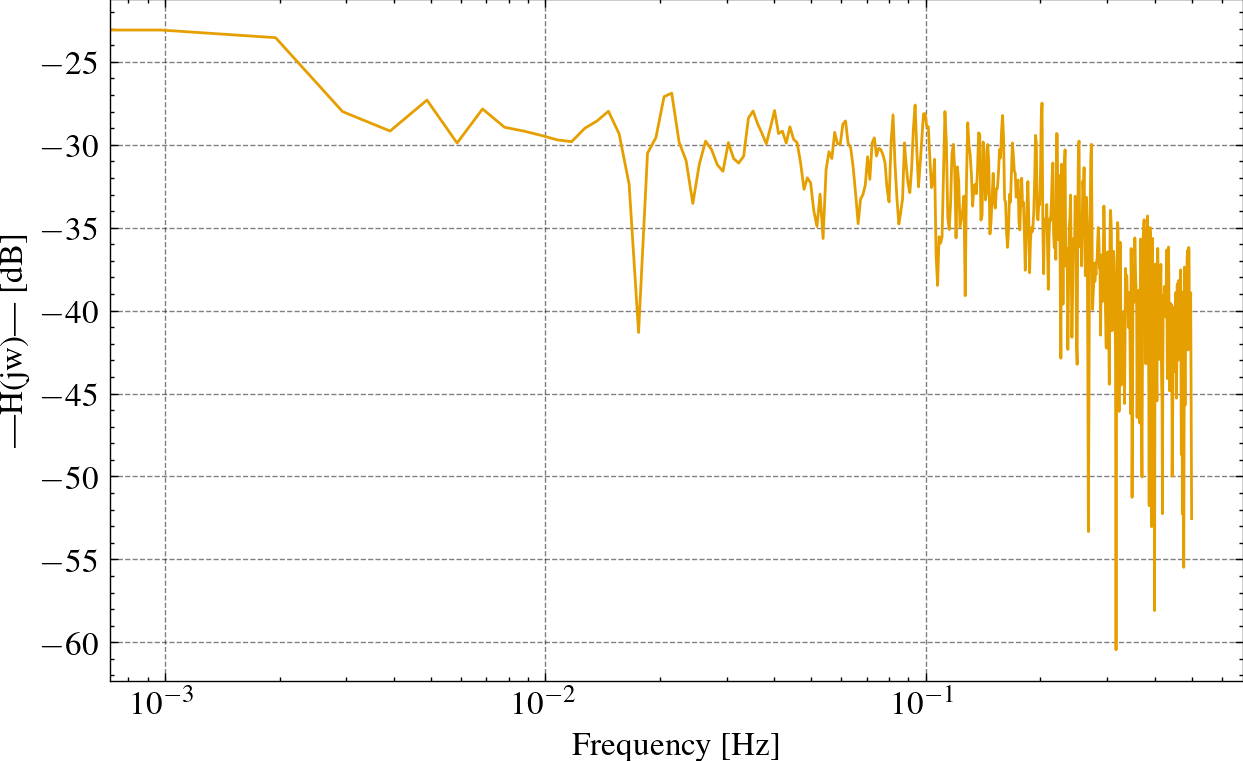

In [47]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage
batt_k_V_OC_coeffs = np.array([10.77420498818087, 5.342402189767365, -13.256712152302418, 23.44686407251436, -20.24985001372384, 6.845076498059946])

battery_params = {
    'batt_N_S': series_cells,
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_R_0': 3e-3,
    'batt_R_1': 5e-3,
    'batt_R_2': 2e-3,
    'batt_R_3': 2e-2,
    'batt_tau_1': 2,
    'batt_tau_2': 900,
    'batt_tau_3': 1800,
    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
}

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i']

resample = '1s'
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample(resample).mean().interpolate(method='time')
initial_SOC = 0.82

# 1) preprocess
u, v_dyn, dt = preprocess_battery_dynamics(
    df=df_train,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC,
    batt_k_V_OC_coeffs=battery_params['batt_k_V_OC_coeffs'],
    R0=series_cells*battery_params['batt_R_0'],
)

# 2) FRF
f, H = estimate_frf(u, v_dyn, dt, nperseg=1024)

# 3) Inspect Bode magnitude
plt.figure()
plt.semilogx(f, 20 * np.log10(np.abs(H) + 1e-16))
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(jw)| [dB]")
plt.grid(True)

# 4) Detect candidate break frequencies (tune min_freq, max_freq as needed)
f_peaks, tau_est = detect_break_frequencies(
    f, H,
    min_freq=1e-9,   # adjust according to your record length
    max_freq=0.1,    # upper practical limit for your excitation
    min_prominence=0.1,
    max_peaks=2,
)

print("Candidate break frequencies [Hz]:", f_peaks)
print("Estimated taus [s]:", tau_est)

tau_bounds = suggest_tau_bounds(tau_est, factor_low=0.2, factor_high=5.0)
for i, (tau_min, tau_max) in enumerate(tau_bounds, start=1):
    print(f"tau_{i} bounds ≈ [{tau_min:.2f}, {tau_max:.2f}] s")

# Sort taus ascending (slowest → fastest or vice-versa depending on what you prefer)
tau_sorted = np.sort(tau_est)  # typically largest τ is slowest branch

# Example: assume tau_sorted[0] is fastest, tau_sorted[1] mid, tau_sorted[2] slowest
tau_bounds = suggest_tau_bounds(tau_sorted[:3], factor_low=0.2, factor_high=5.0)
tau_bounds

In [50]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

resample = '1s'
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample(resample).mean().interpolate(method='time')

# Compute sampling frequency (assuming uniform timestamps)
time_diff = np.diff(df_train.index).astype('timedelta64[s]').astype(float)
sampling_rate = 1 / np.mean(time_diff)  # Average sample rate in Hz

# Perform FFT on voltage data
# voltage = df_train["batt_v"].values

u, v_dyn, dt = preprocess_battery_dynamics(
    df=df_train,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC,
    batt_k_V_OC_coeffs=battery_params['batt_k_V_OC_coeffs'],
    R0=battery_params['batt_R_0'],
)
voltage = v_dyn

n = len(voltage)
freqs = fftfreq(n, d=1/sampling_rate)  # Frequency bins
fft_magnitude = np.abs(fft(voltage))  # Magnitude spectrum

# Find frequency peaks in the FFT magnitude
freq_peaks, freq_properties = find_peaks(fft_magnitude[:n//2], height=np.mean(fft_magnitude))

# Sort and get the top peaks
top_freq_peaks = sorted(zip(freq_peaks, fft_magnitude[freq_peaks]), key=lambda x: x[1], reverse=True)[:5]

# Convert indices to actual frequency values
top_freqs = [(freqs[idx], mag) for idx, mag in top_freq_peaks]

# Print results
for idx, (freq, mag) in enumerate(top_freqs, 1):
    print(f"Peak {idx}: Frequency {freq:.4f} Hz (Period {1/freq:.2f} s), Magnitude {mag:.2f}")

top_freqs = np.array(top_freqs)

Peak 1: Frequency 0.0002 Hz (Period 4800.00 s), Magnitude 17645.56
Peak 2: Frequency 0.0003 Hz (Period 3428.57 s), Magnitude 9448.01
Peak 3: Frequency 0.0005 Hz (Period 2000.00 s), Magnitude 8027.14
Peak 4: Frequency 0.0004 Hz (Period 2400.00 s), Magnitude 5009.66
Peak 5: Frequency 0.0006 Hz (Period 1714.29 s), Magnitude 4675.02
